# A Mathematical Model of Tuberculosis Including Antibiotic Treatment, Vaccination, and Antibiotic Resistance  
## by Antonio Neher  
## Indiana University (2021)

Tuberculosis (TB) is a bacterial infection of the lungs that presents with a persistent cough sometimes including blood, fever, and sudden weight loss. Currently, TB is the most deadly infectious disease in the world claiming the lives of about 1.4 million people every year (WHO: TB, 2020). TB is also known to acquire resistance to the antibiotics used to treat it, and as a strain becomes resistant to more antibiotics, the likelihood that treatment will be successful dramatically decreases. The purpose of this model is to demstrate the consequences of the development of antibiotic resistance in deadly diseases by simulating the spread of TB through a population.  
This model incorporates three versions of a TB infection: Smear-Positive, Smear-Negative, and Non-Pulmonary. Smear-negative and smear-positive refer to whether or not a significant amount TB causing bacteria is present in sputum samples obtained from the patient's lungs. Extra-pulmonary TB is a TB infection that has taken hold in a different part of the body rather than the lungs. Smear-negative TB is less infectious than Smear-positve due to the fact that a significant amout of active bacteria are not present when smear-negative patients cough or sneeze. Similarly, in this model we assume that extra-pulmonary cases of TB are not infectious as they do not contain any infection agent in their sputum.  
In this model, we first build a model of TB and examine how certain characteristics of the disease affect how the disease spreads among a population of 10 million people, roughly the population of a city. Next, we will add vaccination to our model and explore how the spread of the disease changes as we alter the characteristics of the vaccine. Finally, we will incorporate antibiotic resistance into the model. Resistance to antibiotics often arises during treatment as some of the TB cells mutate to develop resistance to the drug and then thrive as the other cells die off due to treatment. In the last stage of our model, we will investigate how the spread of the infection changes due to the development of resistance as well as the effectiveness of the treatment.

# Simplified Model from Abu-Raddad et al., 2009:

## Arrow Diagram and Table of Parameters  
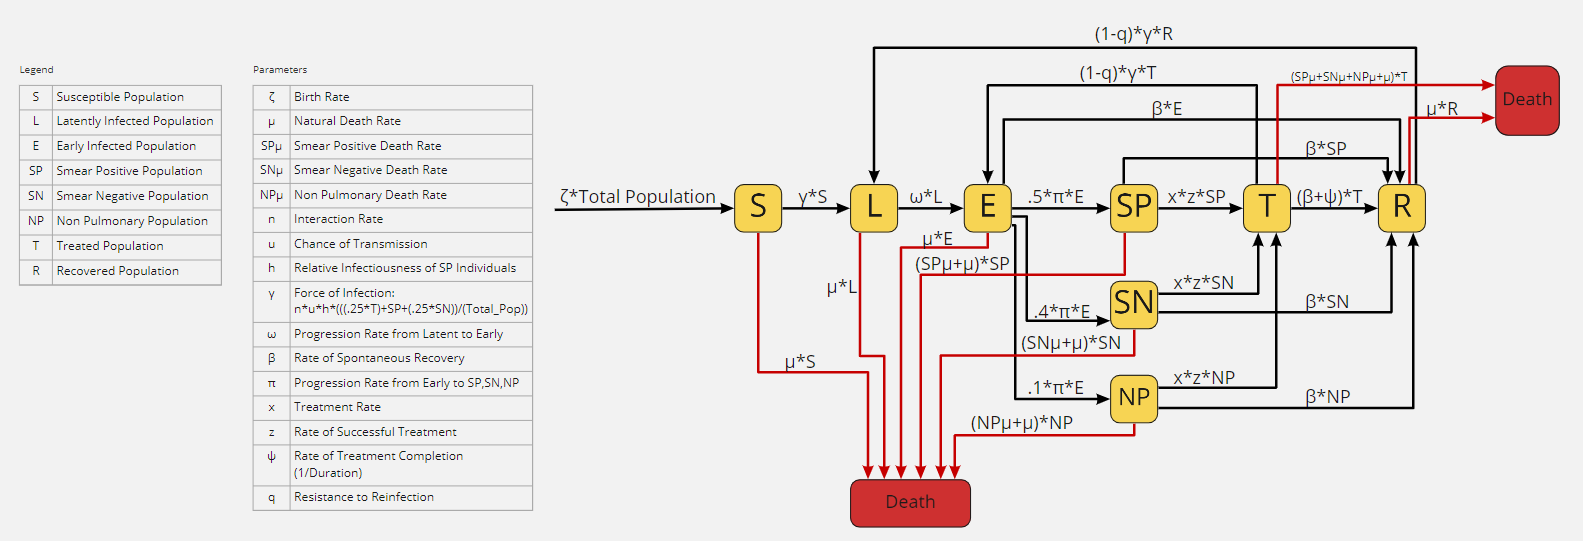

Further discussion of the parameters and reasoning will be made in the report. For now, we can refer to the arrow diagram as a guide to how the model works.

## Original Model:

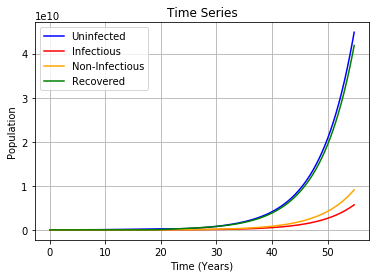

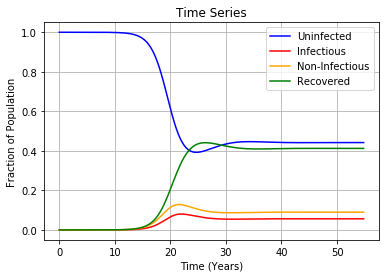

R0: 0.46114543378657546


In [1]:
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt

modelString = '''
#Equations
    #Susceptible
    E1: -> S ; zeta*(Total_Pop)                                #Birth rate
    E2: S -> L ; n*u*h*(((.25*T)+SP+(.25*SN))/(Total_Pop))*S   #Force of Infection
    E3: S -> ; mu*S                                            #Natural Death
    
    #Latent to Early
    E4: L -> E ; omega*L   #Progression to Early
    E5: L -> ; mu*L        #Natural Death
    
    #Exiting Early
    E6: E -> ; mu*E          #natrual Death only
    E7: E -> R ; beta*E      #Spontaneous Recovery
    E8: E -> SP ; .5*pie*E   #Smear positive (50% of Cases)
    E9: E -> SN ; .4*pie*E   #smear negative (40% of Cases)
    E10: E -> NP; .1*pie*E   #non-pulmonary (10% of Cases)
    
    #Exiting Treated
    E11: T -> D; SPmu*T + SNmu*T + NPmu*T                            #TB Death
    E12: T -> ; mu*T                                                 #Natural Death
    E13: T -> R ; beta*T + psi*T                                     #Recovery by treatment and spontaneous
    E14: T -> E ; (1-q)*(n*u*h*(((.25*T)+SP+(.25*SN))/Total_Pop))*T  #Reinfection at 35% rate 
    
    #Exiting Smear Positive
    E15: SP -> D; SPmu*SP             #TB Death
    E16: SP-> ; mu*SP                 #Natural Death
    E17: SP -> R ; beta*SP            #Spontaneous Recovery
    E18: SP -> T ; chi*z*SP           #Treatment
    
    #Exiting Smear Negative
    E19: SN -> D; SNmu*SN             #TB Death
    E20: SN -> ; mu*SN                #Natural Death
    E21: SN -> R ; beta*SN            #Spontaneous Recovery
    E22: SN -> T ; chi*z*SN           #Treatment
    
    #Exiting non-pulmonary
    E23: NP -> D; NPmu*NP             #TB Death
    E24: NP -> ; mu*NP                #Natural Death
    E25: NP -> R ; beta*NP            #Spontaneous Recovery
    E26: NP -> T ; chi*z*NP           #Treatment
    
    #Exiting Recovered
    E27: R -> ; mu*R                                    #Natural Death
    E28: R -> L ;(1-q)*(n*u*h*(((.25*T)+SP+(.25*SN))/Total_Pop))*R   #Reinfection at 35% rate
    
    Total_Pop := S+E+L+R+T+NP+SP+SN

#Add up to 1:
    Uninfected := S/Total_Pop
    Infectious_Frac := (SP+SN+T)/Total_Pop
    Rec_Frac := R/Total_Pop
    Noninfec_Frac := (E+L+NP)/Total_Pop
    
#Other Useful Fractions:
    Treat_Frac := T/Total_Pop
    Infectious_noT_Frac := (SP+SN)/Total_Pop
    #Dead_Frac := D/Total_Pop
    
    #R0 CALCULATIONS: (Rate that group infects others/Rate of clearance from group)
    SP_R0 = ((n*u*h)*(1+(1-q)+(1-q)))/(SPmu+mu+beta+(chi*z))    #(numerators came from E2,E14,E28)/(Denom from E15,16,17,18)
    SN_R0 = .25*((n*u*h)*(1+(1-q)+(1-q)))/(SNmu+mu+beta+(chi*z)) 
    T_R0 := .25*((n*u*h)*(1+(1-q)+(1-q)))/(mu+SPmu+SNmu+NPmu+beta+psi+((1-q)*(n*u*h*(((.25*T)+SP+(.25*SN))/Total_Pop))))
    Total_R0 := (1.5*((n*u*h)*(1+(1-q)+(1-q))))/((2*(SPmu+mu+beta+(chi*z))) + (mu+SPmu+SNmu+NPmu+beta+psi+((1-q)*(n*u*h*(((.25*T)+SP+(.25*SN))/Total_Pop)))))
    
    
#Parameters
    zeta = 5.48E-4     #births per day
    
    #FORCE OF INFECTION
    q = .65       #Percent resistant to reinfection (Originally .65)
    n = .5        #contact rate (Not given in paper) (Orinially 5)
    u = .10       #chance of transmission
    h = 1         #Infectiousness of SP individuals
    
    #PROGRESSION RATES
    omega = .0045     #Latent to Early progression per day
    Edur = .00137     #Duration of Early Infection in days
    pie = 1/Edur      #Early to Disease progression per day (early disease lasts 6 months)
    
    #TREATMENT IDENTIFICATION RATES
    chi = .167    #treatment rate per day (According to Paper)
    z = .80       #rate of succesful treatment (Not Given in Paper)(originally 50)
    
    #RECOVERY RATES
    beta = 2.74E-4   #Spontaneous recovery rate per day
    Tdur = 182.5     #duration of treatment in days
    psi = 1/(Tdur)   #Recovery from succesful treatment per day
    
    #DEATH RATES(VACCINATED AND UNVACCINATED)
    mu = 3.84E-5      #natural Deaths per day = 1/life expectancy in years = 1/70
    SPmu = 6.85E-4    #TB death of SP per day
    SNmu = 2.74E-4    #TB death of SN per day
    NPmu = 2.74E-4    #TB death of NP per day
    
#Initial Values
    S0 = 1E7  #Initial Population
    S = S0
    L0 = 10   #Initial infected
    L = L0
'''
#Time Series
m = te.loada(modelString)
s = m.simulate(0,20000,20000,['Time','S','SP','SN','T','E','L','NP','R'])#,'T'])
plt.plot((s[:,0]/365), s[:,1], label='Uninfected',c='blue')
plt.plot((s[:,0]/365), s[:,2]+s[:,3]+s[:,4], label='Infectious',c='red')
plt.plot((s[:,0]/365), s[:,5]+s[:,6]+s[:,7], label='Non-Infectious',c='orange')
#plt.plot((s[:,0]/365), s[:,9], label='Treated',c='purple')
plt.plot((s[:,0]/365), s[:,8], label='Recovered',c='green')
plt.legend()
plt.title('Time Series')
plt.xlabel('Time (Years)')
plt.ylabel('Population')
plt.grid(True)
plt.show()

#Fractional Time Series
m.resetAll()
s = m.simulate(0,20000,20000,['Time','Uninfected','Infectious_Frac','Noninfec_Frac','Rec_Frac'])#,'Treat_Frac'])
plt.plot((s[:,0]/365), s[:,1], label='Uninfected',c='blue')
plt.plot((s[:,0]/365), s[:,2], label='Infectious',c='red')
plt.plot((s[:,0]/365), s[:,3], label='Non-Infectious',c='orange')
#plt.plot((s[:,0]/365), s[:,5], label='Treated',c='gray')
plt.plot((s[:,0]/365), s[:,4], label='Recovered',c='green')
plt.legend()
plt.title('Time Series')
plt.xlabel('Time (Years)')
plt.ylabel('Fraction of Population')
plt.grid(True)
plt.show()
print('R0: '+ str(m.Total_R0))

Let's examine the first time-series. First, notice how long it takes for the population to start seeing a rise in cases. This is because the time-scale of Tuburculosis is very slow compared to many diseases. For example, many cases do not express symptoms for years following the intial infection. This explains the delay before the infection starts taking hold in our population. Second, since we have included birth rates in our model, total population continues to grow exponentially. This makes it difficult to analyze patterns once the population reaches a steady-state or equilibrium. Therefore, we will use fractions of the population to clearly see trends.  
Now let's look at the second time series where we have graphed the fractions of each group out of the total population. Again, we see that it takes about 15 years before we start noticing a significant number of cases due to the long latency of this disease. This also explains why we see a higher fraction of the population with a non-infectious version of the disease (Latent, Early, and Non-Pulmonary). A maximum of cases occurs at about 22 years followed by the maximum recovered cases at about 26 years. Between these two maxima, it makes sense that we find our minimum fraction of uninfected population at around 25 years. The duration of the epidemic is indicated by the time cases start to rise until the time cases reach a maximum. Here we see an epidemic period of 7 or 8 years. Once steady-state is achieved, we see that at any time about 10% of the population has a non-infectious TB infection and 5% have an infectious case. This totals to a TB prevalence of about 15%. This number is not outrageous when compared to figures found in literature. In a study done about the prevalence of TB in males from 1949 - 1950 prevalence was reported anywhere from 60% to 75% (Vynnycky, 1996). Our prevalence is lower than the reported numbers due to the fact that we have modelled antibiotic treatment whereas people in that time living in rural areas might not have had access to antibiotic treatment. At steady-state, we can also see that the proportion of the population that remained uninfected is about 45% indicating that approximately 55% of the population was infected after 35 years. This number fits our expectations from literature, and may be attributed to the population being isolated from population flow in and out. The model also assumes that everyone can interact with everyone else in the population which is exaggerated compared with reality.  
  
Finally, we see the R0 of our model TB reported. R0, also known as the reproductive number, represents the average number of people that an infected by an infected individual during the course of their illness and is subject to change over time. This R0 value is reported as a sort of "sanity check" to see if our model is somewhat realistic. Compared to literature reported R0 values of .26 to 4.3 (Ma et al., 2018), we can say that our R0 is realistic.

## Now let's scan through some parameters of the model and see how they affect the time series:  
### Scanning Interactions/Day (n):  
This is essentially the implementation of a quarantine. As you decrease the value of n, you are decreasing the number of interactions an individual has per day. We expect to see that as n is increased, there will be a bigger proportion of the population infected and vice versa.

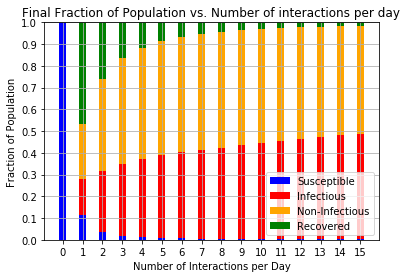

In [2]:
import numpy as np
import matplotlib.pyplot as plt

m = te.loada(modelString)
results = np.empty(shape=(0,5))
#Scan through values for n:
for i in range(0,16):
    m.resetAll()
    m.n = i
    s = m.simulate(0,20000,10000,['Time','Uninfected','Infectious_Frac','Rec_Frac','Noninfec_Frac'])
    results = np.vstack((results,[m.n, m.Uninfected, m.Infectious_Frac, m.Rec_Frac, m.Noninfec_Frac]))

#Formatting the stacked bar plot
ind = np.arange(len(results[:,0]))
width = .35  #Width of bars

Vdata = np.array(results[:,0]).astype(int)
Sdata = np.array(results[:,1])
Idata = np.array(results[:,2])
Rdata = np.array(results[:,3])
Ndata = np.array(results[:,4])

p1 = plt.bar(ind, Sdata, width, color = 'b') #Fraction of S
p2 = plt.bar(ind, Idata, width, bottom=Sdata, color = 'r') #Fraction of Infectous
p3 = plt.bar(ind, Ndata, width, bottom=Sdata+Idata, color = 'orange') #Fraction of Noninfectious
p4 = plt.bar(ind, Rdata, width, bottom=Sdata+Idata+Ndata, color = 'g') #Fraction of Recovered

plt.ylabel('Fraction of Population')
plt.xlabel('Number of Interactions per Day')
plt.title('Final Fraction of Population vs. Number of interactions per day')
plt.grid(True)
plt.xticks(ind, (Vdata))
plt.yticks(np.arange(0,1.1,.1))
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Susceptible', 'Infectious', 'Non-Infectious', 'Recovered'))
plt.show()

Looking at the graph, we can see that our expectations were met. As we increase the value of n, we see that the final proportion of infected individuals rises exponentially, thus the proportion of uninfected individuals decreases. We can also see that at about 7 interactions per day, almost 100% of our population is infected. It is interesting to note that when 0 interactions a day occur, approximately 100% of the population remains uninfected as a result of the perfect quaratine.

### Now try manually scanning through values of n to investigate the changes in the time series and R0:

In [17]:
from ipywidgets import *
def replot(n, duration):
    m = te.loada(modelString)
    m.n = n
    s = m.simulate(0,duration*365,20000,['Time','Uninfected','Infectious_Frac','Noninfec_Frac','Rec_Frac'])
    plt.plot((s[:,0]/365), s[:,1], label='Uninfected',c='blue')
    plt.plot((s[:,0]/365), s[:,2], label='Infectious',c='red')
    plt.plot((s[:,0]/365), s[:,3], label='Non-Infectious',c='orange')
    plt.plot((s[:,0]/365), s[:,4], label='Recovered',c='green')
    plt.legend()
    plt.title('Time Series')
    plt.xlabel('Time (Years)')
    plt.ylabel('Fraction of Population')
    plt.grid(True)
    plt.show()
    print('R0: '+ str(m.Total_R0))
    
style = {'description_width': '100px'}
style1 = {'description_width': '103px'}
layout = {'width': '350px'}
slider1 = FloatSlider(description = 'Interactions/Day:', min=0.0, max=20.0, step=.5, value=.5,continuous_update=False, style=style, layout=layout)
slider2 = IntSlider(description = 'Duration in Years:', min=5, max=100, step=1, value=65, continuous_update=False, style=style1, layout=layout)
interact(replot, n=slider1, duration = slider2);

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='Interactions/Day:', layout=Layout(width='350px'), max=20.0, step=0.5, style=SliderStyle(description_width='100px')), IntSlider(value=65, continuous_update=False, description='Duration in Years:', layout=Layout(width='350px'), min=5, style=SliderStyle(description_width='103px')), Output()), _dom_classes=('widget-interact',))

Notice that as we increase the value of n, not only does does the fraction of infected individuals increase, but the time it takes to reach steady state is decreased drastically. At the maximum of 20 interactions per day, we see that steady state is reached in only 3 years as opposed to the original unchanged model where steady state was reached in 15 years. The steady state fractions are as we expected from the previous stacked bar graph.

### Scanning the Percent Resistance to Reinfection (q):  
Here we are scanning through values for the q parameter. This represents how perfect the immunity of an individual is after they have recovered from the infection. A value of 100% means that recovered individuals cannot be reinfected and have perfect immunity. A value of 0% means that after recovering from infection, individuals are just as susceptible as someone who has never been infected. We expect to see that as q is increased, we will see a smaller proportion of the population infected and therefore, a larger uninfected proportion as there are less infected individuals to infect them.

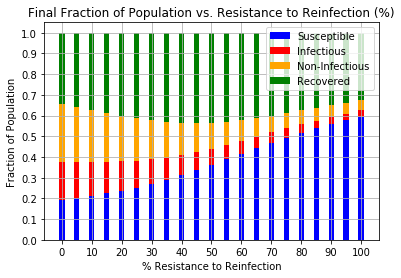

In [4]:
m = te.loada(modelString)
results = np.empty(shape=(0,5))
#Scan through values for q
for i in np.arange(0,1.05,.05):
    m.resetAll()
    m.q = i
    s = m.simulate(0,20000,10000,['Time','Uninfected','Infectious_Frac','Rec_Frac','Noninfec_Frac'])
    results = np.vstack((results,[m.q, m.Uninfected, m.Infectious_Frac, m.Rec_Frac, m.Noninfec_Frac]))

#formatting plot
ind = np.arange(len(results[:,0]))
width = .35

Qdata = np.array(results[:,0])
Qdata.round(decimals=2)
Qdata *= 100
Qdata = Qdata.astype(int)
Sdata = np.array(results[:,1])
Idata = np.array(results[:,2])
Rdata = np.array(results[:,3])
Ndata = np.array(results[:,4])

#Only include everyother ytick to clean up graph
indshort = []
Qdatashort = []
for j in range (0, len(results[:,0]),2):
    indshort.append(ind[j])
    Qdatashort.append(Qdata[j])

p1 = plt.bar(ind, Sdata, width, color = 'b') #Fraction of S
p2 = plt.bar(ind, Idata, width, bottom=Sdata, color = 'r') #Fraction of Infectous
p3 = plt.bar(ind, Ndata, width, bottom=Sdata+Idata, color = 'orange') #Fraction of Noninfectious
p4 = plt.bar(ind, Rdata, width, bottom=Sdata+Idata+Ndata, color = 'g') #Fraction of Recovered

plt.ylabel('Fraction of Population')
plt.xlabel('% Resistance to Reinfection')
plt.title('Final Fraction of Population vs. Resistance to Reinfection (%)')
plt.grid(True)
plt.xticks(indshort, (Qdatashort))
plt.yticks(np.arange(0,1.1,.1))
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Susceptible', 'Infectious', 'Non-Infectious', 'Recovered'))
plt.show()

We can see from the graph that our expectations were met. As the resistance to reinfection is increased, we see a linear decrease in the proportion of infections, and as a result, a nearly linear increase in the proportion of uninfected population. It is interesting to note the trend of the final proportion of Recovered individuals. There seems to be a sweet spot at about 50% resistance where a maximum is reached. At lower than 50% resistances, individuals in the recovered population are more prone to be reinfected, thus the proportion is a little smaller. At greater than 50%, even though individuals are much less likely to leave the recovered population by way of reinfection, there are also much fewer infected cases to recover from in the first place.

### Now try manually scanning through values of q to investigate the changes in the time series and R0:

In [5]:
from ipywidgets import *
def replot1(q, duration):
    m = te.loada(modelString)
    m.q = q/100
    s = m.simulate(0,duration*365,20000,['Time','Uninfected','Infectious_Frac','Noninfec_Frac','Rec_Frac'])
    plt.plot((s[:,0]/365), s[:,1], label='Uninfected',c='blue')
    plt.plot((s[:,0]/365), s[:,2], label='Infectious',c='red')
    plt.plot((s[:,0]/365), s[:,3], label='Non-Infectious',c='orange')
    plt.plot((s[:,0]/365), s[:,4], label='Recovered',c='green')
    plt.legend()
    plt.title('Time Series')
    plt.xlabel('Time (Years)')
    plt.ylabel('Fraction of Population')
    plt.grid(True)
    plt.show()
    print('R0: '+ str(m.Total_R0))
    
style2 = {'description_width': '172px'}
style3 = {'description_width': '103px'}
layout1 = {'width': '370px'}
layout2 = {'width': '300px'}
slider3 = IntSlider(description = 'Resistance to Reinfection (%)', min=0, max=100, step=1, value=65,continuous_update=False, style=style2, layout=layout1)
slider4 = IntSlider(description = 'Duration in Years:', min=5, max=100, step=1, value=65, continuous_update=False, style=style3, layout=layout2)
interact(replot1, q=slider3, duration = slider4);

interactive(children=(IntSlider(value=65, continuous_update=False, description='Resistance to Reinfection (%)', layout=Layout(width='370px'), style=SliderStyle(description_width='172px')), IntSlider(value=65, continuous_update=False, description='Duration in Years:', layout=Layout(width='300px'), min=5, style=SliderStyle(description_width='103px')), Output()), _dom_classes=('widget-interact',))

As we adjust the parameters we can confirm our findings from our initial scan. Additionally we see that the time-scale is not affected as we alter the resistance to reinfection, and the R0 value decreases as the resistance is increased.

### Scanning Treatment Efficacy (Z):  
Finally, let's explore what happens when we scan through values for the efficacy of the antibiotic treatment. A value of 100% means that every treatment is successful, while a value of 0% means that the treatment is completely ineffective against the infection. We expect that as we increase the effectiveness of the treatment the proportion of infected individuals will decrease, and the proportion of recovered individuals will increase. It is important to remember that in our model, individuals undergoing treatment are still infectious and contribute to the spread of the disease. Therefore, they are included in the "Infectious" Group, but if you would like to visualize them separately, select "Yes" from the dropdown menu and the proportion of treated cases will be displayed in gray.

In [6]:
from ipywidgets import *
def replot2(Choice):
    m = te.loada(modelString)
    if(Choice == 'No'):
        results = np.empty(shape=(0,5))
        for i in np.arange(0,1.05,.05):
            m.resetAll()
            m.z = i
            s = m.simulate(0,10000,10000,['Time','Uninfected','Infectious_Frac','Rec_Frac','Noninfec_Frac'])
            results = np.vstack((results,[m.z, m.Uninfected, m.Infectious_Frac, m.Rec_Frac, m.Noninfec_Frac]))

        ind = np.arange(len(results[:,0]))
        width = .35

        Zdata = np.array(results[:,0])
        Zdata.round(decimals=2)
        Zdata *= 100
        Zdata = Qdata.astype(int)
        Sdata = np.array(results[:,1])
        Idata = np.array(results[:,2])
        Rdata = np.array(results[:,3])
        Ndata = np.array(results[:,4])
        
        #Only include everyother ytick to clean up graph
        indshort = []
        Zdatashort = []
        for j in range (0, len(results[:,0]),2):
            indshort.append(ind[j])
            Zdatashort.append(Zdata[j])

        p1 = plt.bar(ind, Sdata, width, color = 'b') #Fraction of S
        p2 = plt.bar(ind, Idata, width, bottom=Sdata, color = 'r') #Fraction of Infectous
        p3 = plt.bar(ind, Ndata, width, bottom=Sdata+Idata, color = 'orange') #Fraction of Noninfectious
        p4 = plt.bar(ind, Rdata, width, bottom=Sdata+Idata+Ndata, color = 'g') #Fraction of Recovered

        plt.ylabel('Fraction of Population')
        plt.xlabel('Efficacy of Treatment (%)')
        plt.title('Final Fraction of Population vs. Efficacy of Treatment')
        plt.grid(True)
        plt.xticks(indshort, (Zdatashort))
        plt.yticks(np.arange(0,1.1,.1))
        plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Uninfected', 'Infectious', 'Non-Infectious', 'Recovered'))
        
    elif(Choice != 'No'):
        results = np.empty(shape=(0,6))
        for i in np.arange(0,1.05,.05):
            m.resetAll()
            m.z = i
            s = m.simulate(0,10000,10000,['Time','Uninfected','Treat_Frac','Infectious_noT_Frac','Rec_Frac','Noninfec_Frac'])
            results = np.vstack((results,[m.z, m.Uninfected,m.Treat_Frac, m.Infectious_noT_Frac, m.Rec_Frac, m.Noninfec_Frac]))

        ind = np.arange(len(results[:,0]))
        width = .35

        Zdata = np.array(results[:,0])
        Zdata.round(decimals=2)
        Zdata *= 100
        Zdata = Qdata.astype(int)
        Sdata = np.array(results[:,1])
        Tdata = np.array(results[:,2])
        Idata = np.array(results[:,3])
        Rdata = np.array(results[:,4])
        Ndata = np.array(results[:,5])
        
        #Only include everyother ytick to clean up graph
        indshort = []
        Zdatashort = []
        for j in range (0, len(results[:,0]),2):
            indshort.append(ind[j])
            Zdatashort.append(Zdata[j])

        p1 = plt.bar(ind, Sdata, width, color = 'b') #Fraction of Susceptibles
        p2 = plt.bar(ind, Tdata, width, bottom=Sdata, color = 'gray') #Fraction of Treated
        p3 = plt.bar(ind, Idata, width, bottom=Sdata+Tdata, color = 'r') #Fraction of Infectous-Treated
        p4 = plt.bar(ind, Ndata, width, bottom=Sdata+Tdata+Idata, color = 'orange') #Fraction of Noninfectious
        p5 = plt.bar(ind, Rdata, width, bottom=Sdata+Tdata+Idata+Ndata, color = 'g') #Fraction of Recovered

        plt.ylabel('Fraction of Population')
        plt.xlabel('Efficacy of Treatment (%)')
        plt.title('Final Fraction of Population vs. Efficacy of Treatment')
        plt.grid(True)
        plt.xticks(indshort, (Zdatashort))
        plt.yticks(np.arange(0,1.1,.1))
        plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Uninfected', 'Treated', 'Infectious', 'Non-Infectious', 'Recovered'))
        
    plt.show()
    
style4 = {'description_width': '165px'}
layout3 = {'width': '200'}
choices = Dropdown(options=["No", "Yes"], description="Display Treated Seperately?", style=style4, layout=layout3)
interact(replot2, Choice=choices);

interactive(children=(Dropdown(description='Display Treated Seperately?', layout=Layout(width='200'), options=('No', 'Yes'), style=DescriptionStyle(description_width='165px'), value='No'), Output()), _dom_classes=('widget-interact',))

As we predicted, as you increase the efficacy of the treatment the proportion of infected individuals is decreased and the proportion of recovered individuals is increased. Additionally, the proportion of Uninfected individuals is also increased. If we adjust the graph so that the treated group is displayed separately, we can see that as we increase the efficacy of treatment, treated individuals quickly make up a greater proportion of the infectious group. As expected, there are no treated individuals when the treatment efficacy is 0%.

### Now try manually scanning through values of z to investigate the changes in the time series and R0:

In [7]:
from ipywidgets import *
def plotchoice(choice):
    if(choice=='No'):
        interact(noplot, z=slider5, duration = slider6)
    elif(choice=='Yes'):
        interact(yesplot, z=slider5, duration = slider6)

def noplot(z, duration):
    m = te.loada(modelString)
    m.z = z/100
    s = m.simulate(0,duration*365,20000,['Time','Uninfected','Infectious_Frac','Noninfec_Frac','Rec_Frac'])
    plt.plot((s[:,0]/365), s[:,1], label='Uninfected',c='blue')
    plt.plot((s[:,0]/365), s[:,2], label='Infectious',c='red')
    plt.plot((s[:,0]/365), s[:,3], label='Non-Infectious',c='orange')
    plt.plot((s[:,0]/365), s[:,4], label='Recovered',c='green')
    plt.legend()
    plt.title('Time Series')
    plt.xlabel('Time (Years)')
    plt.ylabel('Fraction of Population')
    plt.grid(True)
    plt.show()
    print('R0: '+ str(m.Total_R0))
    
def yesplot(z, duration):
    m = te.loada(modelString)
    m.z = z/100
    s = m.simulate(0,duration*365,20000,['Time','Uninfected','Treat_Frac','Infectious_noT_Frac','Noninfec_Frac','Rec_Frac'])
    plt.plot((s[:,0]/365), s[:,1], label='Uninfected',c='blue')
    plt.plot((s[:,0]/365), s[:,2], label='Treated',c='gray')
    plt.plot((s[:,0]/365), s[:,3], label='Infectious (No Treated)',c='red')
    plt.plot((s[:,0]/365), s[:,4], label='Non-Infectious',c='orange')
    plt.plot((s[:,0]/365), s[:,5], label='Recovered',c='green')
    plt.legend()
    plt.title('Time Series')
    plt.xlabel('Time (Years)')
    plt.ylabel('Fraction of Population')
    plt.grid(True)
    plt.show()
    print('R0: '+ str(m.Total_R0))
    
style5 = {'description_width': '146px'}
style6 = {'description_width': '103px'}
style7 = {'description_width': '169px'}
layout4 = {'width': '350px'}
layout5 = {'width': '300px'}
slider5 = IntSlider(description = 'Efficacy of Treatment (%)', min=0, max=100, step=1, value=80,continuous_update=False, style=style5, layout=layout4)
slider6 = IntSlider(description = 'Duration in Years:', min=5, max=100, step=1, value=65, continuous_update=False, style=style6, layout=layout5)
choices1 = Dropdown(options=["No", "Yes"], description="Display Treated Seperately?", style=style7, layout=layout)
interact(plotchoice, choice = choices1);

interactive(children=(Dropdown(description='Display Treated Seperately?', layout=Layout(width='350px'), options=('No', 'Yes'), style=DescriptionStyle(description_width='169px'), value='No'), Output()), _dom_classes=('widget-interact',))

As we reduce the efficacy of the treatement, we see that in addition to an increased proportion of the population being infected, the time scale of the epidemic is also accelerated. With a completely ineffective treatment option, about 95% of the population is infected within 6 years. Contrastingly, we see that with a 100% effective treatment, it takes about 15 years before the epidemic starts to occur.

## Next, let's implement a vaccine in our model:  
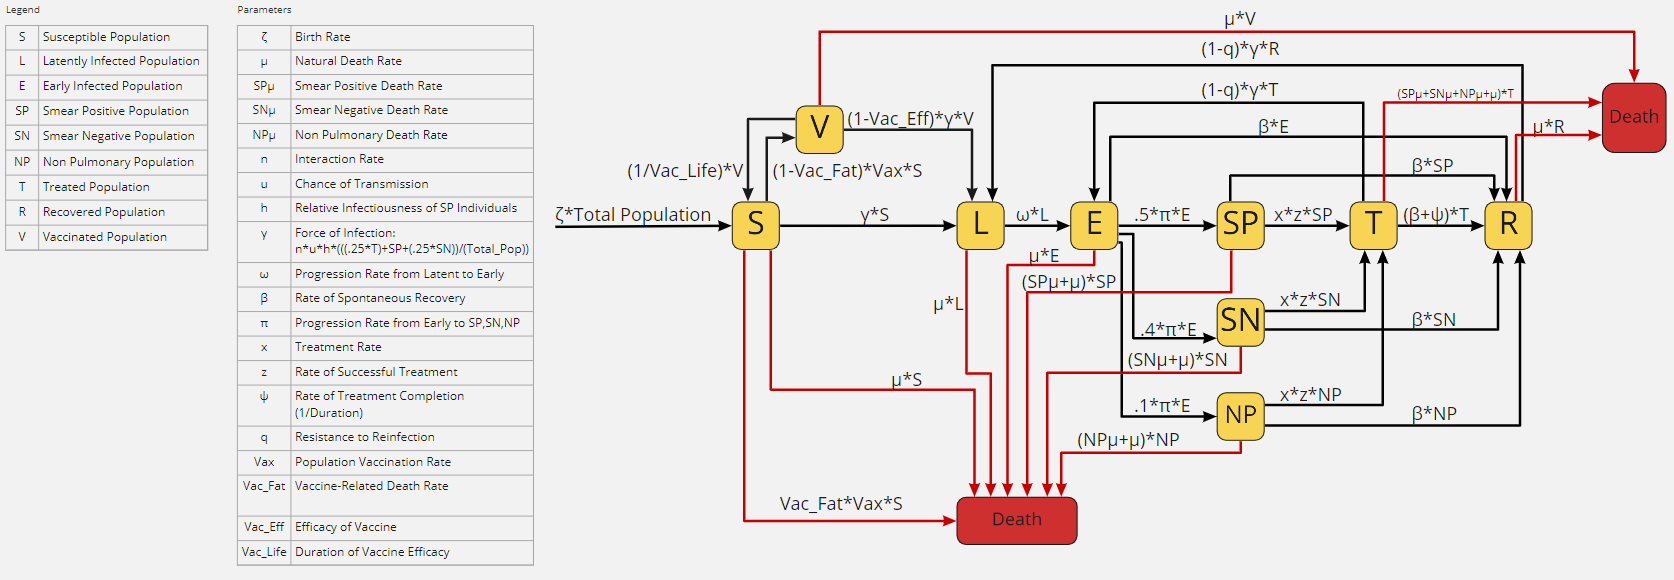
Again, we will discuss the parameters and rational in more detail in the report.

interactive(children=(Dropdown(description='Display Vaccinated Seperately?', layout=Layout(width='350px'), options=('No', 'Yes'), style=DescriptionStyle(description_width='200px'), value='No'), Output()), _dom_classes=('widget-interact',))

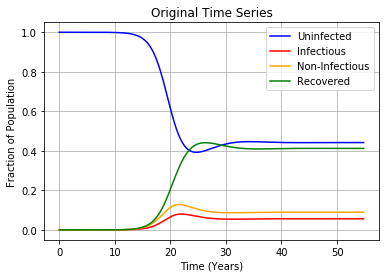

R0: 0.46114543378657546


In [8]:
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *

modelString1 = '''
#Equations
    #Susceptible
    E1: -> S ; zeta*(Total_Pop)                                 #Birth rate
    E2: S -> L ; n*u*h*(((.25*T)+SP+(.25*SN))/(Total_Pop))*S    #Force of Infection
    E3: S -> ; mu*S                                             #Natural Death
    
    #Latent to Early
    E4: L -> E ; omega*L     #Progression to Early
    E5: L -> ; mu*L          #Natural Death
    
    #Exiting Early
    E6: E -> ; mu*E          #natrual Death only
    E7: E -> R ; beta*E      #Recovery (Orignally No spontaneous??) More likely to be only spontaneous
    E8: E -> SP ; .5*pie*E   #Smear positive (50%)
    E9: E -> SN ; .4*pie*E   #smear negative (40%)
    E10: E -> NP ; .1*pie*E   #non-pulmonary (10%)
    
    #Exit Treated
    E11: T -> D; SPmu*T + SNmu*T + NPmu*T                             #TB Death
    E12: T -> ; mu*T                                                 #Natural Death
    E13: T -> R ; beta*T + psi*T                                     #Recovery by treatment and spontaneous
    E14: T -> E ; (1-q)*(n*u*h*(((.25*T)+SP+(.25*SN))/Total_Pop))*T  #Reinfection at 35% rate 
    
    #Exit Smear Positive
    E15: SP -> D; SPmu*SP             #TB Death
    E16: SP-> ; mu*SP                 #Natural Death
    E17: SP -> R ; beta*SP            #Spontaneous Recovery
    E18: SP -> T ; chi*z*SP           #Treatment
    
    #Exit Smear Negative
    E19: SN -> D; SNmu*SN             #TB Death
    E20: SN -> ; mu*SN                #Natural Death
    E21: SN -> R ; beta*SN            #Spontaneous Recovery
    E22: SN -> T ; chi*z*SN           #Treatment
    
    #Exit non-pulmonary
    E23: NP -> D; NPmu*NP             #TB Death
    E24: NP -> ; mu*NP                #Natural Death
    E25: NP -> R ; beta*NP            #Spontaneous Recovery
    E26: NP -> T ; chi*z*NP           #Treatment
    
    #Exit Recovered
    E27: R -> ; mu*R                                                 #Natural Death
    E28: R -> L ;(1-q)*(n*u*h*(((.25*T)+SP+(.25*SN))/Total_Pop))*R   #Reinfection at 35% rate
        
    #VACCINE
    E29: S -> V ; (1-Vac_Fat)*Vax*S                                          #Rate of Succesful Vaccination
    E30: S -> ; Vac_Fat*Vax*S                                                #Vaccine Complications death
    E31: V -> L ; (1-Vac_Eff)*n*u*h*(((.25*T)+SP+(.25*SN))/(Total_Pop))*V    # Vaccine Reduced possibility for infection by Vac_Eff
    E32: V -> ; mu*V                                                         # Natural Death
    E33: V -> S ; (1/Vac_Life)*V                                             #Vaccine efficacy wanes and individuals return to susceptible group
    
    
    Total_Pop := S+E+L+R+T+NP+SP+SN+V

#Add up to 1:
    Sus_Frac := (S)/Total_Pop
    Vac_Frac := V/Total_Pop
    Infectious_Frac := (SP+SN+T)/Total_Pop
    Rec_Frac := R/Total_Pop
    Noninfec_Frac := (E+L+NP)/Total_Pop

#Other Useful Fractions:
    Uninfected := (S+V)/Total_Pop
    Treat_Frac := T/Total_Pop
    Infectious_noT_Frac := (SP+SN)/Total_Pop
    #Dead_Frac := D/Total_Pop
    
    #R0 CALCULATIONS: (Rate that group infects others/Rate of clearance from group)
    SP_R0 = ((n*u*h)*(1+(1-q)+(1-q)))/(SPmu+mu+beta+(chi*z))                                        #(numerators came from E2,E14,E28)/(Denom from E15,16,17,18)
    SN_R0 = .25*((n*u*h)*(1+(1-q)+(1-q)))/(SNmu+mu+beta+(chi*z)) 
    T_R0 := .25*((n*u*h)*(1+(1-q)+(1-q)))/(mu+SPmu+SNmu+NPmu+beta+psi+((1-q)*(n*u*h*(((.25*T)+SP+(.25*SN))/Total_Pop))))
    Total_R0 := (1.5*((n*u*h)*(1+(1-q)+(1-q))))/((2*(SPmu+mu+beta+(chi*z))) + (mu+SPmu+SNmu+NPmu+beta+psi+((1-q)*(n*u*h*(((.25*T)+SP+(.25*SN))/Total_Pop)))))
    
    
#Parameters
    zeta = 5.48E-4                    #births per day
    
    #VACCINE
    Vax =  .2/365                     #Rate of vaccination of susceptibles (Percent/year)
    Vac_Eff = .5                      #Efficacy of vaccination
    Vac_Life = (40*365)               #lifetime of effective vaccine (about 40 years)
    Vac_Comp = 2/1000000              #Risk of Developing BCG-itis  EXPLAIN
    Vac_Comp_Fat = .5                 #Fatality rate of BCG-itis
    Vac_Fat = Vac_Comp*Vac_Comp_Fat   #Combined risk of death following BCG Administration
    
    #FORCE OF INFECTION
    q = .65       #Percent resistant to reinfection (Originally .65)
    n = .5        #contact rate (Not given in paper) (Orinially 5)
    u = .10       #chance of transmission
    h = 1         #Infectiousness of SP individuals
    
    #PROGRESSION RATES
    omega = .0045     #Latent to Early progression per day
    Edur = .00137     #Duration of Early Infection in days
    pie = 1/Edur      #Early to Disease progression per day (early disease lasts 6 months)
    
    #TREATMENT IDENTIFICATION RATES
    chi = .167    #treatment rate per day (According to Paper)
    z = .80       #rate of succesful treatment (Not Given in Paper)(originally 50)
    
    #RECOVERY RATES
    beta = 2.74E-4     #Spontaneous recovery rate per day
    Tdur = 182.5       #duration of treatment in days
    psi = 1/(Tdur)     #Recovery from succesful treatment per day
    
    #DEATH RATES(VACCINATED AND UNVACCINATED)
    mu = 3.84E-5      #natural Deaths per day = 1/life expectancy in years = 1/70
    SPmu = 6.85E-4    #TB death of SP per day
    SNmu = 2.74E-4    #TB death of SN per day
    NPmu = 2.74E-4    #TB death of NP per day
    
#Initial Values
    S0 = 1E7    #Initial Population
    S = S0
    L0 = 1000   #Initial infected
    L = L0
'''
#Fractional Time Series
def plotchoice1(choice):
    if(choice=='No'):
        interact(noplot1);
    elif(choice=='Yes'):
        interact(yesplot1);

def noplot1():
    m = te.loada(modelString1)
    s = m.simulate(0,20000,20000,['Time','Uninfected','Infectious_Frac','Noninfec_Frac','Rec_Frac'])
    plt.plot((s[:,0]/365), s[:,1], label='Uninfected',c='blue')
    plt.plot((s[:,0]/365), s[:,2], label='Infectious',c='red')
    plt.plot((s[:,0]/365), s[:,3], label='Non-Infectious',c='orange')
    plt.plot((s[:,0]/365), s[:,4], label='Recovered',c='green')
    plt.legend()
    plt.title('Vaccinated Time Series')
    plt.xlabel('Time (Years)')
    plt.ylabel('Fraction of Population')
    plt.grid(True)
    plt.show()
    print('R0: '+ str(m.Total_R0))
    
def yesplot1():
    m = te.loada(modelString1)
    s = m.simulate(0,20000,20000,['Time','Sus_Frac','Vac_Frac','Infectious_Frac','Noninfec_Frac','Rec_Frac'])
    plt.plot((s[:,0]/365), s[:,1], label='Susceptible',c='blue')
    plt.plot((s[:,0]/365), s[:,2], label='Vaccinated',c='purple')
    plt.plot((s[:,0]/365), s[:,3], label='Infectious (No Treated)',c='red')
    plt.plot((s[:,0]/365), s[:,4], label='Non-Infectious',c='orange')
    plt.plot((s[:,0]/365), s[:,5], label='Recovered',c='green')
    plt.legend()
    plt.title('Vaccinated Time Series')
    plt.xlabel('Time (Years)')
    plt.ylabel('Fraction of Population')
    plt.grid(True)
    plt.show()
    print('R0: '+ str(m.Total_R0))

style8 = {'description_width': '200px'}
layout6 = {'width': '350px'}
choices2 = Dropdown(options=["No", "Yes"], description="Display Vaccinated Seperately?", style=style8, layout=layout6)
interact(plotchoice1, choice = choices2)

m = te.loada(modelString)
s = m.simulate(0,20000,20000,['Time','Uninfected','Infectious_Frac','Noninfec_Frac','Rec_Frac'])
plt.plot((s[:,0]/365), s[:,1], label='Uninfected',c='blue')
plt.plot((s[:,0]/365), s[:,2], label='Infectious',c='red')
plt.plot((s[:,0]/365), s[:,3], label='Non-Infectious',c='orange')
plt.plot((s[:,0]/365), s[:,4], label='Recovered',c='green')
plt.legend()
plt.title('Original Time Series')
plt.xlabel('Time (Years)')
plt.ylabel('Fraction of Population')
plt.grid(True)
plt.show()
print('R0: '+ str(m.Total_R0))

As we can see from comparing the vaccinated time series to our original time series, the final proportion of uninfected individuals increased by 15% compared to the unvaccinated population. Additionally, we notice that the epidemic period is drawn out from about 7 years to about 12 years in the vaccinated population, and the peaks of infected proportions have been flattened. This drawn out epidemic and flattened curve mean that public health institutions are better able to adapt to the rise in cases. The final proportion of infected individuals is also decreased from about 15% to about 10%.  
When we choose to visualize the vaccinated proportion separately, we see a maximum proportion of about 45% of the population is vaccinated after 10 years. At about 15 years, the proportion starts to decrease. This can be explained by the rise of cases starting at 15 years. Since we only vaccinate the susceptible population, once the susceptible population starts to be infected at a faster rate, there are less susceptibles to vaccinate.

## Now let's scan through some parameters of the model and see how they affect the time series:  
### Scanning the Vaccination Rate of the Population in Percent/Year (Vax):  
Vax is a parameter that expresses the rate that susceptibles are vaccinated as a percent per year. As we scan through values of the vaccination rate, we expect to see that as the vaccination rate goes up, the proportion of vaccinated will increase, the uninfected proportion will increase (Due to the vaccinated being counted among the uninfected), and the infected proportion should decrease as a result of the resistance to infection that comes with the vaccination. This is an interesting parameter to scan through because it allows us to make predictions on how widespread the vaccine has to be in order to eradicate the disease from the population.

In [9]:
from ipywidgets import *

def replot3(choice):
    if(choice=='No'):
        m = te.loada(modelString1)
        results = np.empty(shape=(0,5))
        for i in np.arange(0,.85,.05):
            m.resetAll()
            m.Vax = i/365
            s = m.simulate(0,20000,10000,['Time','Uninfected','Infectious_Frac','Rec_Frac','Noninfec_Frac'])
            results = np.vstack((results,[m.Vax, m.Uninfected, m.Infectious_Frac, m.Rec_Frac, m.Noninfec_Frac]))

        ind = np.arange(len(results[:,0]))
        width = .35

        Vdata = np.array(results[:,0])
        Vdata *= 36500                    #Multiply by 365 and 100 to get %/year
        #Vdata = Vdata.round(decimals=2)
        Vdata = Vdata.astype(int)
        Sdata = np.array(results[:,1])
        Idata = np.array(results[:,2])
        Rdata = np.array(results[:,3])
        Ndata = np.array(results[:,4])

        indshort = []
        Vdatashort = []

        for j in range (0, len(results[:,0]),2):
            indshort.append(ind[j])
            Vdatashort.append(Vdata[j])

        p1 = plt.bar(ind, Sdata, width, color = 'b')                           #Fraction of Uninfected
        p2 = plt.bar(ind, Idata, width, bottom=Sdata, color = 'r')             #Fraction of Infectous
        p3 = plt.bar(ind, Ndata, width, bottom=Sdata+Idata, color = 'orange')  #Fraction of Noninfectious
        p4 = plt.bar(ind, Rdata, width, bottom=Sdata+Idata+Ndata, color = 'g') #Fraction of Recovered

        plt.ylabel('Fraction of Population')
        plt.xlabel('Vaccination Rate (%/Year)')
        plt.title('Final Fraction of Population vs. Vaccination Rate')
        plt.xticks(indshort, (Vdatashort))
        plt.yticks(np.arange(0,1.1,.1))
        plt.grid(True)
        plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Uninfected', 'Infectious', 'Non-Infectious', 'Recovered')) #INCLUDE VACCINATIONS
        
    elif(choice=='Yes'):
        m = te.loada(modelString1)
        results = np.empty(shape=(0,6))
        for i in np.arange(0,.85,.05):
            m.resetAll()
            m.Vax = i/365
            s = m.simulate(0,20000,10000,['Time','Sus_Frac','Vac_Frac','Infectious_Frac','Rec_Frac','Noninfec_Frac'])
            results = np.vstack((results,[m.Vax, m.Sus_Frac, m.Vac_Frac, m.Infectious_Frac, m.Rec_Frac, m.Noninfec_Frac]))

        ind = np.arange(len(results[:,0]))
        width = .35

        Vdata = np.array(results[:,0])
        Vdata *= 36500                    #Multiply by 365 and 100 to get %/year
        #Vdata = Vdata.round(decimals=2)
        Vdata = Vdata.astype(int)
        Sdata = np.array(results[:,1])
        Vacdata = np.array(results[:,2])
        Idata = np.array(results[:,3])
        Rdata = np.array(results[:,4])
        Ndata = np.array(results[:,5])

        indshort = []
        Vdatashort = []

        for j in range (0, len(results[:,0]),2):
            indshort.append(ind[j])
            Vdatashort.append(Vdata[j])

        p1 = plt.bar(ind, Sdata, width, color = 'b')                                   #Fraction of Susceptible
        p2 = plt.bar(ind, Vacdata, width, bottom=Sdata, color = 'purple')               #Fraction of Vaccinated
        p3 = plt.bar(ind, Idata, width, bottom=Sdata+Vacdata, color = 'r')             #Fraction of Infectous
        p4 = plt.bar(ind, Ndata, width, bottom=Sdata+Vacdata+Idata, color = 'orange')  #Fraction of Noninfectious
        p5 = plt.bar(ind, Rdata, width, bottom=Sdata+Vacdata+Idata+Ndata, color = 'g') #Fraction of Recovered

        plt.ylabel('Fraction of Population')
        plt.xlabel('Vaccination Rate (%/Year)')
        plt.title('Final Fraction of Population vs. Vaccination Rate')
        plt.xticks(indshort, (Vdatashort))
        plt.yticks(np.arange(0,1.1,.1))
        plt.grid(True)
        plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Susceptible', 'Vaccinated', 'Infectious', 'Non-Infectious', 'Recovered'))       
    plt.show()
    
style9 = {'description_width': '200px'}
layout7 = {'width': '350px'}
choices3 = Dropdown(options=["No", "Yes"], description="Display Vaccinated Seperately?", style=style9, layout=layout7)
interact(replot3, choice = choices3);

interactive(children=(Dropdown(description='Display Vaccinated Seperately?', layout=Layout(width='350px'), options=('No', 'Yes'), style=DescriptionStyle(description_width='200px'), value='No'), Output()), _dom_classes=('widget-interact',))

Our predictions are show to be correct by the graph presented. We can see that at approximately vaccinating at a rate of approximately 70%/year, we were able to eradicate the TB infection. If we choose to display the vaccinated proportion seperately, our intuitions that the proportion of vaccinated increases with the rate of vaccination is proven correct.

### Now try manually scanning through values of Vax to investigate the changes in the time series and R0:

In [10]:
from ipywidgets import *
def plotchoice2(choice):
    if(choice=='No'):
        interact(noplot2, vax=slider7, duration = slider8);
    elif(choice=='Yes'):
        interact(yesplot2, vax=slider7, duration = slider8);

def noplot2(vax, duration):
    m = te.loada(modelString1)
    m.Vax = vax/36500
    s = m.simulate(0,duration*365,20000,['Time','Uninfected','Infectious_Frac','Noninfec_Frac','Rec_Frac'])
    plt.plot((s[:,0]/365), s[:,1], label='Uninfected',c='blue')
    plt.plot((s[:,0]/365), s[:,2], label='Infectious',c='red')
    plt.plot((s[:,0]/365), s[:,3], label='Non-Infectious',c='orange')
    plt.plot((s[:,0]/365), s[:,4], label='Recovered',c='green')
    plt.legend()
    plt.title('Time Series')
    plt.xlabel('Time (Years)')
    plt.ylabel('Fraction of Population')
    plt.grid(True)
    plt.show()
    print('R0: '+ str(m.Total_R0))
    
def yesplot2(vax, duration):
    m = te.loada(modelString1)
    m.Vax = vax/36500
    s = m.simulate(0,duration*365,20000,['Time','Sus_Frac','Vac_Frac','Infectious_Frac','Noninfec_Frac','Rec_Frac'])
    plt.plot((s[:,0]/365), s[:,1], label='Susceptible',c='blue')
    plt.plot((s[:,0]/365), s[:,2], label='Vaccinated',c='purple')
    plt.plot((s[:,0]/365), s[:,3], label='Infectious',c='red')
    plt.plot((s[:,0]/365), s[:,4], label='Non-Infectious',c='orange')
    plt.plot((s[:,0]/365), s[:,5], label='Recovered',c='green')
    plt.legend()
    plt.title('Time Series')
    plt.xlabel('Time (Years)')
    plt.ylabel('Fraction of Population')
    plt.grid(True)
    plt.show()
    print('R0: '+ str(m.Total_R0))
    
style10 = {'description_width': '152px'}
style11 = {'description_width': '103px'}
style12 = {'description_width': '187px'}
layout8 = {'width': '350px'}
layout9 = {'width': '300px'}
slider7 = IntSlider(description = 'Vaccination Rate (%/Year)', min=0, max=100, step=1, value=20,continuous_update=False, style=style10, layout=layout8)
slider8 = IntSlider(description = 'Duration in Years:', min=5, max=100, step=1, value=65, continuous_update=False, style=style11, layout=layout9)
choices4 = Dropdown(options=["No", "Yes"], description="Display Vaccinated Seperately?", style=style12, layout=layout)
interact(plotchoice2, choice = choices4);

interactive(children=(Dropdown(description='Display Vaccinated Seperately?', layout=Layout(width='350px'), options=('No', 'Yes'), style=DescriptionStyle(description_width='187px'), value='No'), Output()), _dom_classes=('widget-interact',))

Our variable time series confirms the previous graph. Additionally, as a sanity check we can set the Vaccination rate to be 0%/Year to make sure that the resulting time series looks like the original model without a vaccine in place, which it does. It is also interesting to note that as we increase the rate of vaccination, the time before the model reaches a steady state is increased. This is a result of the combined effect of increasing the proportion of vaccinated individuals and the decreased rate at which they are infected which is determined by the efficacy.

### Scanning the Efficacy of the Vaccine at Preventing Infection as a Percentage (Vac_Eff):  
Now we are going to scan through values for Vaccine Efficacy. We expect that as we increase the effectiveness of the vaccine, we will see a smaller proportion of the population become infected and thus a larger proportion of uninfected or susceptible individuals.

In [11]:
from ipywidgets import *

def replot4(choice):
    if(choice=='No'):
        m = te.loada(modelString1)
        results = np.empty(shape=(0,5))
        for i in np.arange(0,1.05,.05): 
            m.resetAll()
            m.Vac_Eff = i
            s = m.simulate(0,20000,10000,['Time','Uninfected','Infectious_Frac','Rec_Frac','Noninfec_Frac'])
            results = np.vstack((results,[m.Vac_Eff, m.Uninfected, m.Infectious_Frac, m.Rec_Frac, m.Noninfec_Frac]))

        ind = np.arange(len(results[:,0]))
        width = .35

        Vdata = np.array(results[:,0])
        Vdata *= 100                    
        #Vdata = Vdata.round(decimals=2)
        Vdata = Vdata.astype(int)
        Sdata = np.array(results[:,1])
        Idata = np.array(results[:,2])
        Rdata = np.array(results[:,3])
        Ndata = np.array(results[:,4])

        indshort = []
        Vdatashort = []

        for j in range (0, len(results[:,0]),2):
            indshort.append(ind[j])
            Vdatashort.append(Vdata[j])

        p1 = plt.bar(ind, Sdata, width, color = 'b')                           #Fraction of Uninfected
        p2 = plt.bar(ind, Idata, width, bottom=Sdata, color = 'r')             #Fraction of Infectous
        p3 = plt.bar(ind, Ndata, width, bottom=Sdata+Idata, color = 'orange')  #Fraction of Noninfectious
        p4 = plt.bar(ind, Rdata, width, bottom=Sdata+Idata+Ndata, color = 'g') #Fraction of Recovered

        plt.ylabel('Fraction of Population')
        plt.xlabel('Vaccination Efficacy (%)')
        plt.title('Final Fraction of Population vs. Vaccination Efficacy')
        plt.xticks(indshort, (Vdatashort))
        plt.yticks(np.arange(0,1.1,.1))
        plt.grid(True)
        plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Uninfected', 'Infectious', 'Non-Infectious', 'Recovered')) #INCLUDE VACCINATIONS
        
    elif(choice=='Yes'):
        m = te.loada(modelString1)
        results = np.empty(shape=(0,6))
        for i in np.arange(0,1.05,.05): 
            m.resetAll()
            m.Vac_Eff = i
            s = m.simulate(0,20000,10000,['Time','Sus_Frac','Vac_Frac','Infectious_Frac','Rec_Frac','Noninfec_Frac'])
            results = np.vstack((results,[m.Vac_Eff, m.Sus_Frac, m.Vac_Frac, m.Infectious_Frac, m.Rec_Frac, m.Noninfec_Frac]))

        ind = np.arange(len(results[:,0]))
        width = .35

        Vdata = np.array(results[:,0])
        Vdata *= 100                  
        #Vdata = Vdata.round(decimals=2)
        Vdata = Vdata.astype(int)
        Sdata = np.array(results[:,1])
        Vacdata = np.array(results[:,2])
        Idata = np.array(results[:,3])
        Rdata = np.array(results[:,4])
        Ndata = np.array(results[:,5])

        indshort = []
        Vdatashort = []

        for j in range (0, len(results[:,0]),2):
            indshort.append(ind[j])
            Vdatashort.append(Vdata[j])

        p1 = plt.bar(ind, Sdata, width, color = 'b')                                   #Fraction of Susceptible
        p2 = plt.bar(ind, Vacdata, width, bottom=Sdata, color = 'purple')               #Fraction of Vaccinated
        p3 = plt.bar(ind, Idata, width, bottom=Sdata+Vacdata, color = 'r')             #Fraction of Infectous
        p4 = plt.bar(ind, Ndata, width, bottom=Sdata+Vacdata+Idata, color = 'orange')  #Fraction of Noninfectious
        p5 = plt.bar(ind, Rdata, width, bottom=Sdata+Vacdata+Idata+Ndata, color = 'g') #Fraction of Recovered

        plt.ylabel('Fraction of Population')
        plt.xlabel('Vaccination Efficacy (%)')
        plt.title('Final Fraction of Population vs. Vaccination Efficacy')
        plt.xticks(indshort, (Vdatashort))
        plt.yticks(np.arange(0,1.1,.1))
        plt.grid(True)
        plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Susceptible', 'Vaccinated', 'Infectious', 'Non-Infectious', 'Recovered'))       
    plt.show()
    
style13 = {'description_width': '200px'}
layout10 = {'width': '350px'}
choices5 = Dropdown(options=["No", "Yes"], description="Display Vaccinated Seperately?", style=style13, layout=layout10)
interact(replot4, choice = choices5);

interactive(children=(Dropdown(description='Display Vaccinated Seperately?', layout=Layout(width='350px'), options=('No', 'Yes'), style=DescriptionStyle(description_width='200px'), value='No'), Output()), _dom_classes=('widget-interact',))

As we predicted, when we increase the efficacy of the vaccine, we observe the proportion of infected individuals being reduced. If we view the vaccinated proportion seperately, we can also observe that since the vaccinated population is less likely to be infected, the proportion of vaccinated individuals rises at a faster rate than the proportion of susceptible individuals. Finally, we should note that at the default rate of vaccination of 20%/year, the efficacy of said vaccination should be at least 85% to completely eradicate the infection.

### Now try manually scanning through values of Vac_Eff to investigate the changes in the time series and R0:

In [12]:
from ipywidgets import *
def plotchoice3(choice):
    if(choice=='No'):
        interact(noplot3, vaceff=slider9, duration = slider10);
    elif(choice=='Yes'):
        interact(yesplot3, vaceff=slider9, duration = slider10);

def noplot3(vaceff, duration):
    m = te.loada(modelString1)
    m.Vac_Eff = vaceff/100
    s = m.simulate(0,duration*365,20000,['Time','Uninfected','Infectious_Frac','Noninfec_Frac','Rec_Frac'])
    plt.plot((s[:,0]/365), s[:,1], label='Uninfected',c='blue')
    plt.plot((s[:,0]/365), s[:,2], label='Infectious',c='red')
    plt.plot((s[:,0]/365), s[:,3], label='Non-Infectious',c='orange')
    plt.plot((s[:,0]/365), s[:,4], label='Recovered',c='green')
    plt.legend()
    plt.title('Time Series')
    plt.xlabel('Time (Years)')
    plt.ylabel('Fraction of Population')
    plt.grid(True)
    plt.show()
    print('R0: '+ str(m.Total_R0))
    
def yesplot3(vaceff, duration):
    m = te.loada(modelString1)
    m.Vac_Eff = vaceff/100
    s = m.simulate(0,duration*365,20000,['Time','Sus_Frac','Vac_Frac','Infectious_Frac','Noninfec_Frac','Rec_Frac'])
    plt.plot((s[:,0]/365), s[:,1], label='Susceptible',c='blue')
    plt.plot((s[:,0]/365), s[:,2], label='Vaccinated',c='purple')
    plt.plot((s[:,0]/365), s[:,3], label='Infectious',c='red')
    plt.plot((s[:,0]/365), s[:,4], label='Non-Infectious',c='orange')
    plt.plot((s[:,0]/365), s[:,5], label='Recovered',c='green')
    plt.legend()
    plt.title('Time Series')
    plt.xlabel('Time (Years)')
    plt.ylabel('Fraction of Population')
    plt.grid(True)
    plt.show()
    print('R0: '+ str(m.Total_R0))
    
style14 = {'description_width': '119px'}
style15 = {'description_width': '103px'}
style16 = {'description_width': '187px'}
layout11 = {'width': '350px'}
slider9 = IntSlider(description = 'Vaccine Efficacy (%)', min=0, max=100, step=1, value=20,continuous_update=False, style=style14, layout=layout11)
slider10 = IntSlider(description = 'Duration in Years:', min=5, max=100, step=1, value=65, continuous_update=False, style=style15, layout=layout11)
choices6 = Dropdown(options=["No", "Yes"], description="Display Vaccinated Seperately?", style=style16, layout=layout11)
interact(plotchoice3, choice = choices6);

interactive(children=(Dropdown(description='Display Vaccinated Seperately?', layout=Layout(width='350px'), options=('No', 'Yes'), style=DescriptionStyle(description_width='187px'), value='No'), Output()), _dom_classes=('widget-interact',))

The time series confirms our findings from the previous graph. If we visualize the vaccinated fraction seperately, it is also interesting to note that as we increase the efficacy of the vaccine, the maximum proportion of vaccinated individuals does not change. Rather, we see that the proportion of vaccinated individuals is decreased less over a wider time range as the efficacy is increased.

## Finally, let's consider the development of antibiotic resistance in our model:  
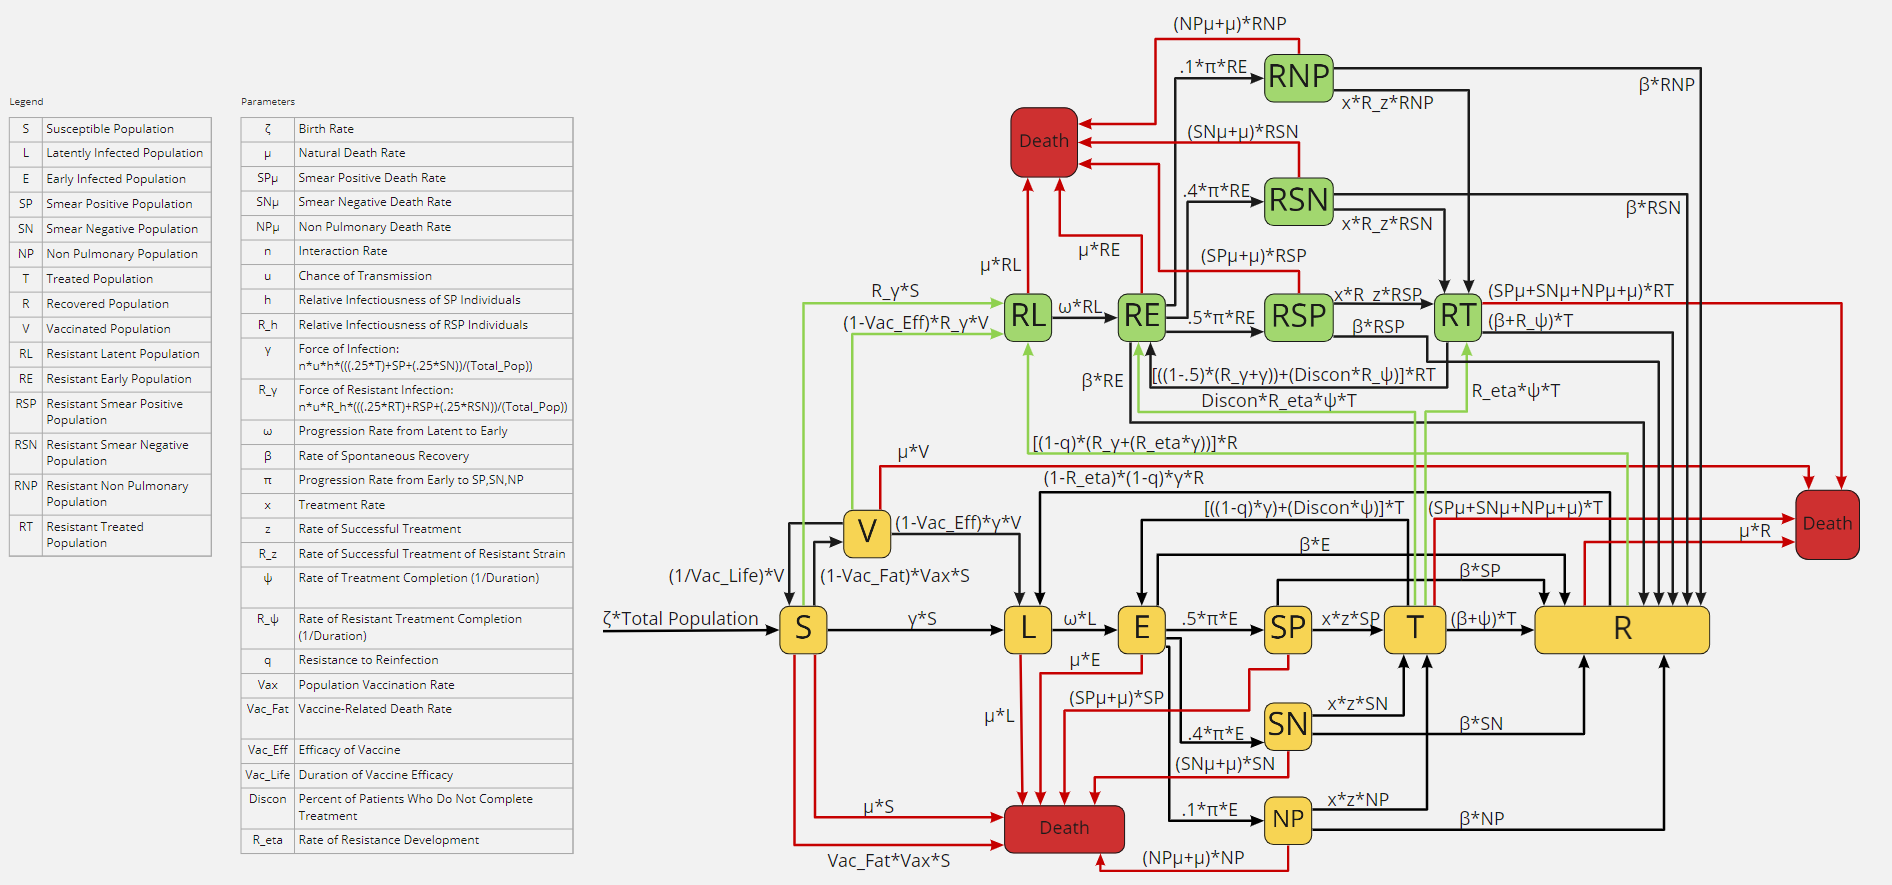

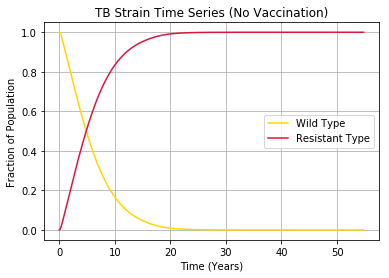

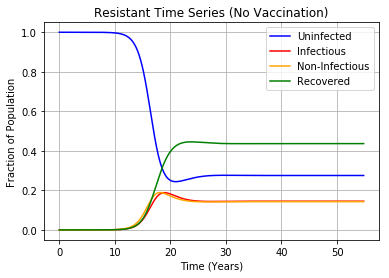

interactive(children=(Dropdown(description='Which model would you like to compare to?', layout=Layout(width='410px'), options=('Original', 'Vaccinated', 'Resistant + Vaccine'), style=DescriptionStyle(description_width='260px'), value='Original'), Output()), _dom_classes=('widget-interact',))

In [18]:
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt

modelString2 = '''
#Equations
    #Susceptible
    E1: -> S ; zeta*(Total_Pop)                                       #Birth rate
    E2: S -> L ; n*u*h*(((.25*T)+SP+(.25*SN))/(Total_Pop))*S          #Force of Infection
    E3: S -> RL; n*u*R_h*(((.25*RT)+RSP+(.25*RSN))/(Total_Pop))*S     #Force of Infection by Resistant Strain #Might Consider reducing h of resistant strains to account for cost of resistance
    E4: S -> V ; (1-Vac_Fat)*Vax*S                                    #Rate of Succesful Vaccination
    E5: S -> VD ; Vac_Fat*Vax*S                                       #Vaccine Complications death 
    E6: S -> ; mu*S                                                   #Natural Death
    
    #VACCINE
    E7: V -> L ; (1-Vac_Eff)*n*u*h*(((.25*T)+SP+(.25*SN))/(Total_Pop))*V         # Vaccine Reduced possibility for infection by Vac_Eff
    E8: V -> RL ;  (1-Vac_Eff)*n*u*R_h*(((.25*RT)+RSP+(.25*RSN))/(Total_Pop))*V  # Vaccine Reduced possibility for Resistant Infection by Vac_Eff
    E9: V -> ; mu*V                                                              # Natural Death
    E10: V -> S ; (1/Vac_Life)*V                                                 #Vaccine efficacy wanes and individuals return to susceptible group
    
    #Latent to Early
    E11: L -> E ; omega*L       #Progression to Early
    E12: RL -> RE; omega*RL     #RESISTANT progression to Early
    E13: L -> ; mu*L            #Natural Death
    E14: RL -> ; mu*RL          #Natural Death
    
    #Exiting Early
    E15: E -> ; mu*E            #natrual Death only
    E16: E -> R ; beta*E        #Recovery (spontaneous)
    E17: E -> SP ; .5*pie*E     #Smear positive (50%)
    E18: E -> SN ; .4*pie*E     #smear negative (40%)
    E19: E -> NP ; .1*pie*E     #non-pulmonary (10%)
    
    #Exiting RESISTANT Early
    E20: RE -> ; mu*RE          #Natural Death
    E21: RE -> R ; beta*RE      #Spontaneous Recovery
    E22: RE -> RSP ; .5*pie*RE  #Smear positive (50%)
    E23: RE -> RSN ; .4*pie*RE  #Smear positive (40%)
    E24: RE -> RNP ; .1*pie*RE  #Smear positive (10%)
    
    #Exit Treated
    E25: T -> D; SPmu*T + SNmu*T + NPmu*T                                           #TB Death
    E26: T -> ; mu*T                                                                #Natural Death
    E27: T -> R ; beta*T + psi*T                                                    #Recovery by treatment and spontaneous
    E28: T -> E ; ((1-q)*(n*u*h*(((.25*T)+SP+(.25*SN))/Total_Pop)) + Discon*psi)*T  #Reinfection at 35% rate and rate at which people stop taking their medication
    E29: T -> RT ; R_eta*psi*T                                                      #RESISTANCE develops during treatment at rate of 17.7%
    E30: T -> RE ; Discon*R_eta*psi*T                                               #Stopped taking drug and consequently developed resistance
    
    #Exit RESISTANT Treated
    E31: RT -> D; SPmu*RT + SNmu*RT + NPmu*RT                                         #TB Death
    E32: RT -> ; mu*RT                                                                #Natural Death
    E33: RT -> R ; beta*RT + R_psi*RT                                                 #Spontaneous and Treated Recovery
    E34: RT -> RE ; .5*(n*u*h*(((.25*(T))+(SP)+(.25*(SN)))/Total_Pop))*RT             #Reinfection at 50% rate to account for additional propagation of resistance
    E35: RT -> RE ; .5*(n*u*R_h*(((.25*(RT))+(RSP)+(.25*(RSN)))/Total_Pop))*RT        #Reinfection by Resistant Population at 50% rate
    E36: RT -> RE ; Discon*R_psi*RT                                                   #Stopped taking drug too early (THE PROBLEM)
    
    #Exit Smear Positive
    E37: SP -> D; SPmu*SP           #TB Death
    E38: SP-> ; mu*SP               #Natural Death
    E39: SP -> R ; beta*SP          #Spontaneous Recovery
    E40: SP -> T ; chi*z*SP         #Treatment

    #Exit RESISTANT Smear Positive
    E41: RSP -> D; SPmu*RSP         #TB Death
    E42: RSP -> ; mu*RSP            #Natural Death
    E43: RSP -> R ; beta*RSP        #Spontaneous Recovery
    E44: RSP -> RT ; chi*R_z*RSP    #Succesful Treatment
    
    #Exit Smear Negative
    E45: SN -> D; SNmu*SN           #TB Death
    E46: SN -> ; mu*SN              #Natural Death
    E47: SN -> R ; beta*SN          #Spontaneous Recovery
    E48: SN -> T ; chi*z*SN         #Treatment
    
    #Exit RESISTANT Smear Negative
    E49: RSN -> D ; SNmu*RSN        #TB Death
    E50: RSN -> ; mu*RSN            #Natural Death
    E51: RSN -> R ; beta*RSN        #Spontaneous Recovery
    E52: RSN -> RT ; chi*R_z*RSN    #Succesful Treatment
    
    #Exit non-pulmonary
    E53: NP -> D; NPmu*NP           #TB Death
    E54: NP -> ; mu*NP              #Natural Death
    E55: NP -> R ; beta*NP          #Spontaneous Recovery
    E56: NP -> T ; chi*z*NP         #Treatment
    
    #Exit RESISTANT Non-Pulmonary
    E57: RNP -> D ; NPmu*RNP        #TB Death
    E58: RNP -> ; mu*RNP            #Natural Death
    E59: RNP -> R ; beta*RNP        #Spontaneous Recover
    E60: RNP -> RT ; chi*R_z*RNP    #Succesful Treatment
    
    #Exit Recovered
    E61: R -> ; mu*R                                                           #Natural Death
    E62: R -> L ;(1-R_eta)*(1-q)*(n*u*h*(((.25*T)+SP+(.25*SN))/Total_Pop))*R   #Reinfection at 35% rate
    E63: R -> RL ; R_eta*(1-q)*(n*u*h*(((.25*T)+SP+(.25*SN))/Total_Pop))*R     #RESISTANT Reinfection at 17.7% of 35% rate
    E64: R -> RL ; (1-q)*(n*u*R_h*(((.25*RT)+RSP+(.25*RSN))/Total_Pop))*R      #Reinfection by Resistant Population at 35% rate
    
    Total_Pop := S+E+L+R+T+NP+SP+SN + RL+RE+RSP+RSN+RNP+RT + V
    Active_Cases := E+L+T+NP+SP+SN + RL+RE+RSP+RSN+RNP+RT
    
#Below add up to 1:
    Uninfected := (S+V)/Total_Pop
    Infectious_Frac := (SP+SN+T+RSP+RSN+RT)/Total_Pop
    Rec_Frac := R/Total_Pop
    Noninfec_Frac := (E+L+NP+RE+RL+RNP)/Total_Pop
    
#Other Useful Fractions:
    Treat_Frac := (T+RT)/Total_Pop
    
    #ADD TO 1:
    Res_Frac := (RL+RE+RSP+RSN+RNP+RT)/Active_Cases
    Wild_Frac := (E+L+T+NP+SP+SN)/Active_Cases
    
    #Dead_Frac := D/Total_Pop
    
    #R0 CALCULATIONS: (Rate that group infects others/Rate of clearance from group)
    #SP_R0 = ((n*u*h)*(1+(1-q)+(1-q)))/(SPmu+mu+beta+(chi*z))
    #SN_R0 = .25*((n*u*h)*(1+(1-q)+(1-q)))/(SNmu+mu+beta+(chi*z))
    #T_R0 := .25*((n*u*h)*(1+(1-q)+(1-q)))/(mu+SPmu+SNmu+NPmu+beta+psi+((1-q)*(n*u*h*(((.25*T)+SP+(.25*SN))/Total_Pop))))
    #Total_R0 := (1.5*((n*u*h)*(1+(1-q)+(1-q))))/((2*(SPmu+mu+beta+(chi*z))) + (mu+SPmu+SNmu+NPmu+beta+psi+((1-q)*(n*u*h*(((.25*T)+SP+(.25*SN))/Total_Pop)))))
    
    
#Parameters
    zeta = 5.48E-4     #births per day
    
    #FORCE OF INFECTION
    q = .65       #Percent resistant to reinfection (Originally .65)
    n = .5        #contact rate (Not given in paper) (Orinially 5)
    u = .10       #chance of transmission
    h = 1         #Infectiousness of SP individuals
    
    #PROGRESSION RATES
    omega = .0045  #Latent to Early progression per day
    Edur = .00137  #Duration of Early Infection in days
    pie = 1/Edur   #Early to Disease progression per day (early disease lasts 6 months)
    
    #TREATMENT IDENTIFICATION RATES
    chi = .167     #treatment rate per day (According to Paper)
    z = .80        #rate of succesful treatment (Not Given in Paper)
    
    #TREATMENT RATES
    beta = 2.74E-4               #Spontaneous recovery rate per day
    Tdur = 182.5                 #duration of treatment in days
    psi = 1/(Tdur)               #Recovery from succesful treatment per day
    Variable_Discon = .53        #Default is SAT
    SAT_Discon = (1-.53)         #53% patients complete treatment with SAT
    DOPT_Discon = (1-.89)        #89 patients complete treatment with DOPT
    Discon = (1-Variable_Discon)
    
    #DEATH RATES(VACCINATED AND UNVACCINATED)
    mu = 3.84E-5      #natural Deaths per day = 1/life expectancy in years = 1/70
    SPmu = 6.85E-4    #TB death of SP per day
    SNmu = 2.74E-4    #TB death of SN per day
    NPmu = 2.74E-4    #TB death of NP per day
    
    #RESISTANT TB RATES
    R_eta = .1        #Percent of resistant reinfection (.117)
    R_Tdur = 365      #Treatment for resistant TB can last much longer than normal (in days)
    R_psi = 1/R_Tdur  #Recovery from succesful treatment of Resistant Strain per day
    R_z = .5          #Succesful treatment of resistant TB (.5)
    R_h = .8          #Accounts for energy cost of Resistance
    
    #VACCINE RATES
    Vax = .2/365                     #Rate of vaccination of susceptibles
    Vac_Eff = .5                     #Efficacy of vaccination
    Vac_Life = (40*365)              #lifetime of effective vaccine (about 40 years)
    Vac_Comp = 2/1000000             #Risk of Developing BCG-itis  EXPLAIN
    Vac_Comp_Fat = .5                #Fatality rate of BCG-itis
    Vac_Fat = Vac_Comp*Vac_Comp_Fat  #Combined risk of death following BCG Administration
    
    
#Initial Values
    S0 = 1E7  #Initial Population
    S = S0
    L0 = 10   #Initial infected
    L = L0
'''
#Strain Time Series
m = te.loada(modelString2)
m.Vax = 0
s = m.simulate(0,20000,20000,['Time','Wild_Frac','Res_Frac'])
plt.plot((s[:,0]/365), s[:,1], label='Wild Type',c='gold')
plt.plot((s[:,0]/365), s[:,2], label='Resistant Type',c='crimson')
plt.legend()
plt.title('TB Strain Time Series (No Vaccination)')
plt.xlabel('Time (Years)')
plt.ylabel('Fraction of Population')
plt.grid(True)
plt.show()
#Group Time Series
m.resetAll()
m.Vax = 0
s = m.simulate(0,20000,20000,['Time','Uninfected','Infectious_Frac','Noninfec_Frac','Rec_Frac'])
plt.plot((s[:,0]/365), s[:,1], label='Uninfected',c='blue')
plt.plot((s[:,0]/365), s[:,2], label='Infectious',c='red')
plt.plot((s[:,0]/365), s[:,3], label='Non-Infectious',c='orange')
plt.plot((s[:,0]/365), s[:,4], label='Recovered',c='green')
plt.legend()
plt.title('Resistant Time Series (No Vaccination)')
plt.xlabel('Time (Years)')
plt.ylabel('Fraction of Population')
plt.grid(True)
plt.show()

def compareto(choice):
    if(choice=='Original'):
        m = te.loada(modelString)
        plt.title('Original Time Series')
    elif(choice=='Vaccinated'):
        m = te.loada(modelString1)
        plt.title('Vaccinated Time Series')
    elif(choice=='Resistant + Vaccine'):
        m = te.loada(modelString2)
        plt.title('Resistance and Vaccine Time Series')
    
    s = m.simulate(0,20000,20000,['Time','Uninfected','Infectious_Frac','Noninfec_Frac','Rec_Frac'])
    plt.plot((s[:,0]/365), s[:,1], label='Uninfected',c='blue')
    plt.plot((s[:,0]/365), s[:,2], label='Infectious',c='red')
    plt.plot((s[:,0]/365), s[:,3], label='Non-Infectious',c='orange')
    plt.plot((s[:,0]/365), s[:,4], label='Recovered',c='green')
    plt.legend()
    plt.xlabel('Time (Years)')
    plt.ylabel('Fraction of Population')
    plt.grid(True)
    plt.show()
    
style17 = {'description_width': '260px'}
layout12 = {'width': '410px'}
choices7 = Dropdown(options=['Original', 'Vaccinated', 'Resistant + Vaccine'], description='Which model would you like to compare to?', style=style17, layout=layout12)
interact(compareto, choice = choices7);

First let's take a general look at the time series of the resistant model compared to the original. With the resistance model, we can see that the epidemic is intensified as indicated by the slightly larger maximum proportion reached by the infected groups and the shortened epidemic timescale. 
Compared to the Vaccinated time series, we see much more drastic differences in both the intensity of the epidemic phase as well as the final proportion of the population that is infected.  
Finally, as we compare the resistant model without vaccination to the resistant model with vaccination included, we can see that the epidemic has been flattened and spread out when we include a vaccine. We can also note that there is an increased proportion of the population that remains uninfected once the model reaches steady-state.

### Scanning the Efficacy of Treatment as a Percentage (z):  
As noted above, in an environment without antibiotic treatment, the wild type TB is selected for due to the energy cost that is associated with a strain having resistance. However, in an environment with antibiotic treatment, we expect to see the resistant strain become dominant. To test this, we will scan through the values of the rate at which individuals are treated once more, but this time paying more attention to the proportions of the two strains.

In [14]:
from ipywidgets import *

def replot5(choice):
    if(choice=='Strains'):
        m = te.loada(modelString2)
        for k in range(2):
            results = np.empty(shape=(0,3))
            for i in np.arange(0,1.05,.05):
                m.resetAll()
                m.Vax *= k
                m.z = i
                m.R_z = i*.375
                s = m.simulate(0,20000,10000,['Time','Wild_Frac','Res_Frac'])
                results = np.vstack((results,[m.z, m.Wild_Frac, m.Res_Frac]))

            ind = np.arange(len(results[:,0]))
            width = .35

            Vdata = np.array(results[:,0])
            Vdata *= 100                   
            #Vdata = Vdata.round(decimals=2)
            Vdata = Vdata.astype(int)
            Wdata = np.array(results[:,1])
            Rdata = np.array(results[:,2])

            indshort = []
            Vdatashort = []

            for j in range (0, len(results[:,0]),2):
                indshort.append(ind[j])
                Vdatashort.append(Vdata[j])

            p1 = plt.bar(ind, Wdata, width, color = 'gold')                         #Fraction of Wild
            p2 = plt.bar(ind, Rdata, width, bottom=Wdata, color = 'crimson')        #Fraction of Resistant

            plt.ylabel('Fraction of Population')
            plt.xlabel('Efficacy of Treatment (%)')
            if(k==0):
                plt.title('Final Fraction of Population vs. Treatment Efficacy (No Vaccination)')
            else:
                plt.title('Final Fraction of Population vs. Treatment Efficacy')
            plt.xticks(indshort, (Vdatashort))
            plt.yticks(np.arange(0,1.1,.1))
            plt.grid(True)
            plt.legend((p1[0], p2[0]), ('Wild Type', 'Resistant Type'))       
            plt.show()
        
    elif(choice=='Groups'):
        m = te.loada(modelString2)
        for k in range(2):
            results = np.empty(shape=(0,5))
            for i in np.arange(0,1.05,.05):
                m.resetAll()
                m.Vax *= k
                m.z = i
                m.R_z = i*.375
                s = m.simulate(0,20000,10000,['Time','Uninfected','Infectious_Frac','Rec_Frac','Noninfec_Frac'])
                results = np.vstack((results,[m.z, m.Uninfected, m.Infectious_Frac, m.Rec_Frac, m.Noninfec_Frac]))

            ind = np.arange(len(results[:,0]))
            width = .35

            Vdata = np.array(results[:,0])
            Vdata *= 100                    
            #Vdata = Vdata.round(decimals=2)
            Vdata = Vdata.astype(int)
            Sdata = np.array(results[:,1])
            Idata = np.array(results[:,2])
            Rdata = np.array(results[:,3])
            Ndata = np.array(results[:,4])

            indshort = []
            Vdatashort = []

            for j in range (0, len(results[:,0]),2):
                indshort.append(ind[j])
                Vdatashort.append(Vdata[j])

            p1 = plt.bar(ind, Sdata, width, color = 'b')                           #Fraction of Uninfected
            p2 = plt.bar(ind, Idata, width, bottom=Sdata, color = 'r')             #Fraction of Infectous
            p3 = plt.bar(ind, Ndata, width, bottom=Sdata+Idata, color = 'orange')  #Fraction of Noninfectious
            p4 = plt.bar(ind, Rdata, width, bottom=Sdata+Idata+Ndata, color = 'g') #Fraction of Recovered

            plt.ylabel('Fraction of Population')
            plt.xlabel('Efficacy of Treatment (%)')
            if(k==0):
                plt.title('Final Fraction of Population vs. Treatment Efficacy (No Vaccination)')
            else:
                plt.title('Final Fraction of Population vs. Treatment Efficacy')
            plt.xticks(indshort, (Vdatashort))
            plt.yticks(np.arange(0,1.1,.1))
            plt.grid(True)
            plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Uninfected', 'Infectious', 'Non-Infectious', 'Recovered'))
            plt.show()

style18 = {'description_width': '225px'}
layout13 = {'width': '350px'}
choices8 = Dropdown(options=["Strains", "Groups"], description="Visualize Strain or Group Proportions?", style=style18, layout=layout13)
interact(replot5, choice = choices8);

interactive(children=(Dropdown(description='Visualize Strain or Group Proportions?', layout=Layout(width='350px'), options=('Strains', 'Groups'), style=DescriptionStyle(description_width='225px'), value='Strains'), Output()), _dom_classes=('widget-interact',))

As expected, as we increase the efficacy of the antibiotic treatment, the resistant strain of TB becomes more fit and dominates over the wild type. This change occurs rather quickly as the resistant type of TB has an immense advantage over the non-resistant strain in the presence of antibiotics. Vaccination seems to have no effect on the ratio of wild to resistant TB because the vaccine treats them the same. When looking at the groups, we can see that infected proportion decreases at a similar rate regardless of whether the vaccine is included in the model. However, the final proportions of the infected populations are slightly lower when we include a vaccine in our model. Seeing as though the inclusion of a vaccine only seems to reduce the scale of our results, and since we are more interested in studying the effects of an antibiotic resistant strain, we will not continue to seperate by whether or not vaccination is included and always include vaccination in our model.

### Now lets manually adjust treatment efficacy to analyze the affect on our time series:

In [15]:
from ipywidgets import *
def replot6(z, duration):
    #Strain Time Series
    m = te.loada(modelString2)
    m.z = z/100
    m.R_z = (z/100)*.375
    s = m.simulate(0,duration*365,20000,['Time','Wild_Frac','Res_Frac'])
    plt.plot((s[:,0]/365), s[:,1], label='Wild Type',c='gold')
    plt.plot((s[:,0]/365), s[:,2], label='Resistant Type',c='crimson')
    plt.legend()
    plt.title('TB Strain Time Series')
    plt.xlabel('Time (Years)')
    plt.ylabel('Fraction of Population')
    plt.grid(True)
    plt.show()
    #Group Time Series
    m.resetAll()
    m.z = z/100
    m.R_z = (z/100)*.375
    s = m.simulate(0,duration*365,20000,['Time','Uninfected','Infectious_Frac','Noninfec_Frac','Rec_Frac'])
    plt.plot((s[:,0]/365), s[:,1], label='Uninfected',c='blue')
    plt.plot((s[:,0]/365), s[:,2], label='Infectious',c='red')
    plt.plot((s[:,0]/365), s[:,3], label='Non-Infectious',c='orange')
    plt.plot((s[:,0]/365), s[:,4], label='Recovered',c='green')
    plt.legend()
    plt.title('Resistant Time Series')
    plt.xlabel('Time (Years)')
    plt.ylabel('Fraction of Population')
    plt.grid(True)
    plt.show()
    
style19 = {'description_width': '132px'}
style20 = {'description_width': '103px'}
layout14 = {'width': '330px'}
layout15 = {'width': '300px'}
slider11 = IntSlider(description = 'Treatment Efficacy (%)', min=0, max=100, step=1, value=65,continuous_update=False, style=style19, layout=layout14)
slider12 = IntSlider(description = 'Duration in Years:', min=5, max=100, step=1, value=65, continuous_update=False, style=style20, layout=layout15)
interact(replot6, z=slider11, duration = slider12);

interactive(children=(IntSlider(value=65, continuous_update=False, description='Treatment Efficacy (%)', layout=Layout(width='330px'), style=SliderStyle(description_width='132px')), IntSlider(value=65, continuous_update=False, description='Duration in Years:', layout=Layout(width='300px'), min=5, style=SliderStyle(description_width='103px')), Output()), _dom_classes=('widget-interact',))

Observing the time series as we scan through different treatment efficacy values, we can confirm our first our findings from our intial scan. As we manipulate the treatment efficacy we can start to see the goals of an ideal treatment. What efficacy of treatment preserves the largest number of uninfected individuals but also minimizes the proportion of resistant TB? In this model the rate of treatment and the efficacy of the treatment are directly correlated, so we can extrapolate and ask a similar question for the rate of treatment. Is there an ideal treatment rate that results in the maximum uninfected proportion and the minimum proportion of resistant TB, and if there is, would it be ethical to treat TB patients at a lower rate than what the healthcare system can provide?

### Now let's explore the effect of patients stopping their treatment:  
The treatment for Tuberculosis involves long periods of daily antibiotics up to 20 months in severe cases. These treatments may also come with uncomfortable side effects such as nausea and diarrhoea. In many cases, patients do not complete the full course of treatment which leads to increased rates of development of antibiotic resistant strains of Tuberculosis. Here, we can investigate the effects of using one of two methods for treatment. The first, Self-Administered Therapy (SAT), involves the patient acquiring the treatment drugs and taking them on their own. The second, Direct Observed Preventative Therapy (DOPT), involves a healthcare representative administering each dose of medication to the patient. While more costly, DOPT has been shown to increase the successful completion of therapy by around 35%, and thereby decreasing the chance that a antiobiotic resistant strain of Tuberculosis will emerge. Finally, we will also include "Perfect Cooperation" treatement option that assumes that every patient succesfully completes the treatment as prescribed.

In [16]:
from ipywidgets import *

def replot7(choice):
    if(choice=='Strains'):
        for k in range(3):
            #Strain Time Series
            m = te.loada(modelString2)
            if(k==1):
                m.Discon = m.DOPT_Discon
            elif(k==0):
                m.Discon = m.SAT_Discon
            elif(k==2):
                m.Discon = 0
            s = m.simulate(0,20000,20000,['Time','Wild_Frac','Res_Frac'])
            plt.plot((s[:,0]/365), s[:,1], label='Wild Type',c='gold')
            plt.plot((s[:,0]/365), s[:,2], label='Resistant Type',c='crimson')
            plt.legend()
            if(k==1):
                plt.title('TB Strain Time Series (DOPT)')
            elif(k==0):
                plt.title('TB Strain Time Series (SAT)')
            elif(k==2):
                plt.title('TB Strain Time Series (Perfect Cooperation)')
            plt.xlabel('Time (Years)')
            plt.ylabel('Fraction of Population')
            plt.grid(True)
            plt.show()
        
    elif(choice=='Groups'):
        for k in range(3):
            #Group Time Series
            m = te.loada(modelString2)
            if(k==1):
                m.Discon = m.DOPT_Discon
            elif(k==0):
                m.Discon = m.SAT_Discon
            elif(k==2):
                m.Discon = 0
            s = m.simulate(0,20000,20000,['Time','Uninfected','Infectious_Frac','Noninfec_Frac','Rec_Frac'])
            plt.plot((s[:,0]/365), s[:,1], label='Uninfected',c='blue')
            plt.plot((s[:,0]/365), s[:,2], label='Infectious',c='red')
            plt.plot((s[:,0]/365), s[:,3], label='Non-Infectious',c='orange')
            plt.plot((s[:,0]/365), s[:,4], label='Recovered',c='green')
            plt.legend()
            if(k==1):
                plt.title('Resistant and Vaccinated Time Series (DOPT)')
            elif(k==0):
                plt.title('Resistant and Vaccinated Time Series (SAT)')
            elif(k==2):
                plt.title('Resistant and Vaccinated Time Series (Perfect Cooperation)')
            plt.xlabel('Time (Years)')
            plt.ylabel('Fraction of Population')
            plt.grid(True)
            plt.show()
            
            
style21 = {'description_width': '225px'}
layout16 = {'width': '350px'}
choices9 = Dropdown(options=["Strains", "Groups"], description="Visualize Strain or Group Proportions?", style=style21, layout=layout16)
interact(replot7, choice = choices9);

interactive(children=(Dropdown(description='Visualize Strain or Group Proportions?', layout=Layout(width='350px'), options=('Strains', 'Groups'), style=DescriptionStyle(description_width='225px'), value='Strains'), Output()), _dom_classes=('widget-interact',))

Analyzing the graphs reveals that there is only a very slight difference between each of the situations of treatment. What we can notice, though, is a slight delay in the time it takes for the resistant TB strain to become dominant over the wild type as treatment is completed at a higher rate. Additionally when we look at the group time series we see that the proportion of uninfected individuals is increased slightly as the rate of successful treatment completion is increased.

# References:  
Abu-Raddad, L. J., Sabatelli, L., Achterberg, J. T., Sugimoto, J. D., Longini, I. M., Dye, C., &amp; Halloran, M. E. (2009). Epidemiological benefits of more-effective tuberculosis vaccines, drugs, and diagnostics. Proceedings of the National Academy of Sciences, 106(33), 13980-13985. doi:10.1073/pnas.0901720106  
	[Inspiring Paper]  

Cruz, A. T., &amp; Starke, J. R. (2018). Completion Rate and Safety of Tuberculosis Infection Treatment With Shorter Regimens. Pediatrics, 141(2). doi:10.1542/peds.2017-2838  
	[Presented the rates at which patients stop their therapy]  

Executive Summary. (2020). World Drug Report World Drug Report 2020, 10-24. doi:10.18356/ceb25f4c-en  
	[Reported the prevalence of MDR-TB]  

Information Sheet Observed Rate of Vaccine Reactions: Bacille Calmette-Guérin (BCG) Vaccine. (april 2012). World Health Organization Global Vaccine Safety, Immunization, Vaccines and Biologicals.  
	[Reported the fatality data for BCG Vaccinations]  

Lotte A, ten Dam HG, Henderson R (1988). Second IUATLD study on complications induced by intradermal BCG vaccination. Bulletin of the International Union Against Tuberculosis and Lung Disease, 63(2):47–59. (Sub-citation of Information Sheet, 2012)  

Talbot E, Perkins MD, Silva SFM, Frothingham R (1997). Disseminated Bacille Calmette-Guérin disease after vaccination: case report and review. Clinical Infectious Diseases, 24:1139–46. (Sub-citation of Information Sheet, 2012)  

Institute of Medicine (US). Facing the Reality of Drug-Resistant Tuberculosis in India: Challenges and Potential Solutions: Summary of a Joint Workshop by the Institute of Medicine, the Indian National Science Academy, and the Indian Council of Medical Research. Washington (DC): National Academies Press (US); 2012. 4, Preventing Transmission of Drug-Resistant TB. Available from: https://www.ncbi.nlm.nih.gov/books/NBK100392/   
	[Reported on the fitness of Resistant TB Strains]  

Ma, Y., Horsburgh, C. R., White, L. F., &amp; Jenkins, H. E. (2018). Quantifying TB transmission: A systematic review of reproduction number and serial interval estimates for tuberculosis. Epidemiology and Infection, 146(12), 1478-1494. doi:10.1017/s0950268818001760  
	[Reported R0 values for TB]  

Ndjeka, N., Schnippel, K., Master, I., Meintjes, G., Maartens, G., Romero, R., . . . Conradie, F. (2018). High treatment success rate for multidrug-resistant and extensively drug-resistant tuberculosis using a bedaquiline-containing treatment regimen. European Respiratory Journal, 52(6), 1801528. doi:10.1183/13993003.01528-2018  
	[Reported the efficacy of antibiotic treatment against TB]  

Nguipdop-Djomo, P., Heldal, E., Rodrigues, L. C., Abubakar, I., &amp; Mangtani, P. (2016). Duration of BCG protection against tuberculosis and change in effectiveness with time since vaccination in Norway: A retrospective population-based cohort study. The Lancet Infectious Diseases, 16(2), 219-226. doi:10.1016/s1473-3099(15)00400-4   
	[Reported on the efficacy of the BCG Vaccination]  

Vynnycky, Emilia; (1996) An investigation of the transmission dynamics of M. tuberculosis. PhD thesis, London School of Hygiene & Tropical Medicine. DOI: https://doi.org/10.17037/PUBS.00682231  
	[Reported on the uninhibited prevalence of TB]  

World Health Organization (WHO): consolidated guidelines on drug-resistant tuberculosis treatment. Geneva: World Health Organization; 2019. Licence: CC BY-NC-SA 3.0 IGO.  
	[Reported on the lengths of MDR-TB Treatment]  


World Health Organization (WHO): Tuberculosis (TB). (2020, October 14). Retrieved December 18, 2020, from https://www.who.int/news-room/fact-sheets/detail/tuberculosis
	[Provided general background information about TB]